In [9]:
import deepxde as dde
import os
os.environ["DDEBACKEND"] = "pytorch"
import numpy as np
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import sys
sys.path.append("../")

from src.gap_data_utils import *

%matplotlib inline

In [60]:
def load_preprocess_data():
    # Load and preprocess the data
    zarr_path = "~/shared-public/mind_the_chl_gap/U-Net_with_CHL_pred.zarr"
    zarr_ds = xr.open_zarr(zarr_path)["gapfree_pred"]

    # Load gappy data (level 3)
    level3_path = "~/shared-public/mind_the_chl_gap/IO.zarr"
    level3_ds = xr.open_zarr(level3_path).sel(
        lat=slice(zarr_ds.lat.values.max(), zarr_ds.lat.values.min()),
        lon=slice(zarr_ds.lon.values.min(), zarr_ds.lon.values.max()),
    )
    # Extract latitude and longitude extents to determine height and width
    lat = level3_ds.lat.values
    lon = level3_ds.lon.values

    # Set a time slice for the datasets
    time_slice = slice("2022-01-01", "2022-12-31")  # Adjust as needed
    gappy_data = level3_ds.sel(time=time_slice)

    return gappy_data, lat, lon


def stack_data(gappy_data, flatten=True):
    # Variables to include in the branch net
    variables = ["CHL_cmes-level3", "sst", "u_wind", "v_wind", "air_temp", "ug_curr"]

    # Prepare the data by stacking variables for each time slice
    stacked_data = np.stack([gappy_data[var].values for var in variables], axis=1)
    stacked_data = np.transpose(
        stacked_data, (0, 2, 3, 1)
    )  # Shape: (train_size, height, width, num_variables)
    if flatten:
        timesteps, w, h, channels = stacked_data.shape
        stacked_data = stacked_data.reshape(timesteps, w * h, channels)
    return stacked_data


def get_random_coords(gappy_data, n_samples):
    m = gappy_data.shape[0]
    coord_array = np.empty((m, n_samples), dtype=float)
    for t_idx in range(m):
        chl_data = gappy_data[t_idx, :, 0]
        valid_coords = np.argwhere(~np.isnan(chl_data))
        if len(valid_coords) > 0:
            selected_coords = valid_coords[
                np.random.choice(len(valid_coords), n_samples, replace=False)
            ]
            coord_array[t_idx] = selected_coords.flatten()
    return coord_array.astype(int)

In [178]:
# def norm_data(x):
# mn = np.nanmean(x)
# sd = np.nanstd(x)
# return (x - mn) / sd


def norm_data(array):
    return (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array))


def norm_data_bychannel(x, channel_dim=2):
    n_channels = x.shape[-1]
    channels = np.split(x, n_channels, axis=channel_dim)
    normed_data = []
    for channel in channels:
        normed_data.append(norm_data(channel.squeeze()))
    return np.stack(normed_data, axis=channel_dim)

In [179]:
gappy_data, lat, lon = load_preprocess_data()
stacked_data = stack_data(gappy_data, flatten=True)
stacked_data = norm_data_bychannel(stacked_data)
stacked_data = np.nan_to_num(stacked_data, nan=0.0)
train_ims, test_ims = split_train_test(stacked_data, frac_train=0.8)

In [184]:
train_inds = get_random_coords(train_ims, 100)
test_inds = get_random_coords(test_ims, 100)

In [185]:
def sample_data(data, inds):
    if len(data.shape) > 3:
        timesteps, w, h, channels = data.shape
        data = data.reshape(timesteps, w * h, channels)
    result = data[np.arange(data.shape[0])[:, None], inds, :]
    return result

In [186]:
y_train = sample_data(train_ims, train_inds)[:, :, 0]
y_test = sample_data(test_ims, test_inds)[:, :, 0]

In [187]:
x_train = np.nan_to_num(train_ims.reshape(train_ims.shape[0], -1), nan=0.0)
x_test = np.nan_to_num(test_ims.reshape(test_ims.shape[0], -1), nan=0.0)

In [188]:
print(
    f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}, train_inds shape: {train_inds.shape}"
)
print(
    f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}, test_inds shape: {test_inds.shape}"
)

x_train shape: (292, 253440), y_train shape: (292, 100), train_inds shape: (292, 100)
x_test shape: (73, 253440), y_test shape: (73, 100), test_inds shape: (73, 100)


In [189]:
# DeepONet setup
m = x_train.shape[1]  # 253440
dim_x = train_inds.shape[1]  # index/sensor dimension

net = dde.nn.DeepONet(
    [m, 512, 512, 128],  # Branch net architecture
    [dim_x, 128, 128],  # Trunk net architecture
    "relu",
    "Glorot normal",
)

data = dde.data.Triple(
    X_train=(x_train, train_inds.astype(np.float32)),
    y_train=y_train,
    X_test=(x_test, test_inds.astype(np.float32)),
    y_test=y_test,
)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["mean l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

Compiling model...
'compile' took 0.000152 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.37e+09]    [1.10e+09]    [7.84e+06]    


In [119]:
with torch.no_grad():
    out = model.predict((x_test, test_inds.astype(np.float32)))

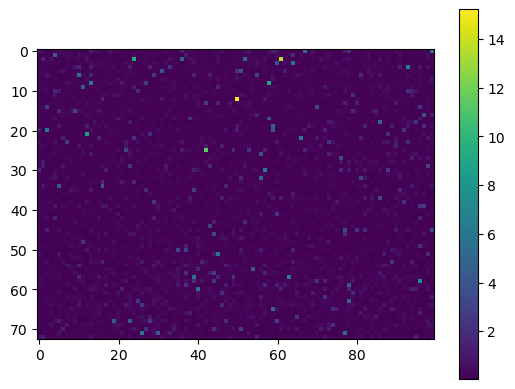

In [124]:
plt.imshow(y_test)
plt.colorbar()

In [118]:
x_test.shape, test_inds.shape

((73, 253440), (73, 100))